In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras

In [2]:
fashion_mnist = keras.datasets.fashion_mnist
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist.load_data()

1. Plot 16 random samples from the training set with the corresponding labels.

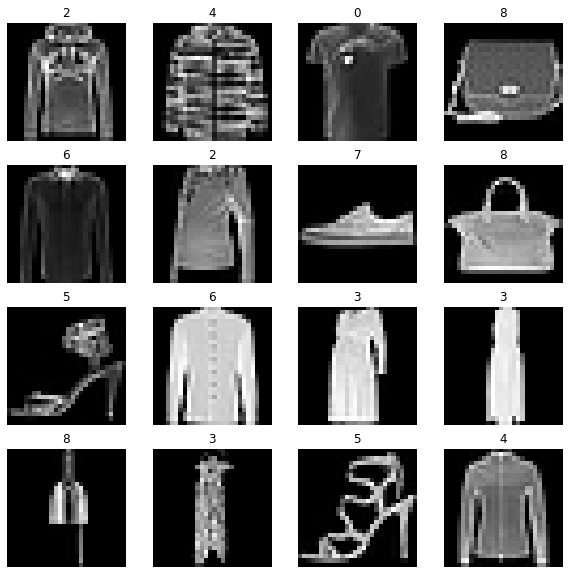

In [3]:
import matplotlib.pyplot as plt
import random

fig, axes = plt.subplots(4, 4, figsize=(10, 10))
for i in range(16):
    index = random.randint(0, len(X_train_full))
    axes[i//4, i%4].imshow(X_train_full[index].reshape(28, 28), cmap='gray')
    axes[i//4, i%4].set_title(y_train_full[index])
    axes[i//4, i%4].axis('off')

2. Train a multilayer perceptron to achieve as good accuracy as you can. There are numerous hyperparameters that we discussed in class which you can tweak, for instance: learning rate, number of and
size of hidden layers, activation function and regularization (e.g. Ridge (known here as L2), and early
stopping). You should make a structured search for the best hyperparameters that you can find.

In [4]:
print(X_train_full.shape, X_train_full.dtype)

(60000, 28, 28) uint8


In [4]:
# rescaling the data down to 0-1 range and creating validation data, since I am going to use gradient descent
X_valid, X_train = X_train_full[:5000] / 255.0, X_train_full[5000:] / 255.0
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]
X_test = X_test / 255.0

In [5]:
# predefined class names from the dataset
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", "Sandal",
               "Shirt", "Sneaker", "Bag", "Ankle boot"]

In [6]:
def build_model(hp):
    activation = hp.Choice('activation', values=['relu'])

    model = keras.models.Sequential([
        keras.layers.Conv2D(hp.Int('filters_1', min_value=32, max_value=128, step=32),
                            kernel_size=hp.Choice('kernel_size_1', values=[3, 5]),
                            activation=activation,
                            input_shape=(28, 28, 1)), 
        keras.layers.MaxPooling2D(pool_size=(2, 2)),
        keras.layers.Conv2D(hp.Int('filters_2', min_value=64, max_value=256, step=64),
                            kernel_size=hp.Choice('kernel_size_2', values=[3, 5]),
                            activation=activation),
        keras.layers.MaxPooling2D(pool_size=(2, 2)),
        keras.layers.Flatten(),
        keras.layers.Dense(hp.Int('units', min_value=200, max_value=400, step=10), activation=activation),
        keras.layers.Dense(hp.Int('units_2', min_value=0, max_value=200, step=10), activation=activation),
        keras.layers.Dense(10, activation='softmax')
     ])

    model.compile(loss='sparse_categorical_crossentropy',
                  optimizer=keras.optimizers.SGD(learning_rate=hp.Choice('learning_rate', values=[0.1, 0.08, 0.12])),
                  metrics=['accuracy'])

    return model

In [7]:
import keras_tuner as kt
from kerastuner.tuners import RandomSearch
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=8,
    executions_per_trial=3,
    directory='tuner_dir',
    project_name='fashion_mnist_tuning_14') # this is the result of the last tuning, if you want to see other test results, change the project name to the corresponding one

INFO:tensorflow:Reloading Tuner from tuner_dir\fashion_mnist_tuning_14\tuner0.json


C:\Users\dimit\AppData\Local\Temp/ipykernel_15672/3395238585.py:2: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import RandomSearch


In [8]:
tuner.search_space_summary()

Search space summary
Default search space size: 8
activation (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu'], 'ordered': False}
filters_1 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 128, 'step': 32, 'sampling': 'linear'}
kernel_size_1 (Choice)
{'default': 3, 'conditions': [], 'values': [3, 5], 'ordered': True}
filters_2 (Int)
{'default': None, 'conditions': [], 'min_value': 64, 'max_value': 256, 'step': 64, 'sampling': 'linear'}
kernel_size_2 (Choice)
{'default': 3, 'conditions': [], 'values': [3, 5], 'ordered': True}
units (Int)
{'default': None, 'conditions': [], 'min_value': 200, 'max_value': 400, 'step': 10, 'sampling': 'linear'}
units_2 (Int)
{'default': None, 'conditions': [], 'min_value': 0, 'max_value': 200, 'step': 10, 'sampling': 'linear'}
learning_rate (Choice)
{'default': 0.1, 'conditions': [], 'values': [0.1, 0.08, 0.12], 'ordered': True}


In [9]:
X_train_subset = X_train[:2000]
y_train_subset = y_train[:2000]
tuner.search(X_train_subset, y_train_subset, epochs=10, validation_data=(X_valid, y_valid))

INFO:tensorflow:Oracle triggered exit


In [10]:
tuner.results_summary()

Results summary
Results in tuner_dir\fashion_mnist_tuning_14
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 5 summary
Hyperparameters:
activation: relu
filters_1: 128
kernel_size_1: 3
filters_2: 192
kernel_size_2: 3
units: 330
units_2: 80
learning_rate: 0.1
Score: 0.8056666652361552

Trial 4 summary
Hyperparameters:
activation: relu
filters_1: 128
kernel_size_1: 3
filters_2: 64
kernel_size_2: 3
units: 370
units_2: 80
learning_rate: 0.12
Score: 0.8027333418528239

Trial 7 summary
Hyperparameters:
activation: relu
filters_1: 32
kernel_size_1: 3
filters_2: 256
kernel_size_2: 3
units: 310
units_2: 40
learning_rate: 0.08
Score: 0.8024666905403137

Trial 2 summary
Hyperparameters:
activation: relu
filters_1: 64
kernel_size_1: 5
filters_2: 128
kernel_size_2: 3
units: 220
units_2: 190
learning_rate: 0.1
Score: 0.7992000182469686

Trial 6 summary
Hyperparameters:
activation: relu
filters_1: 64
kernel_size_1: 3
filters_2: 64
kernel_size_2: 3
units: 320
units_2: 50


In [11]:
tuner.get_best_models()[0].summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 128)       1280      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 128)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 192)       221376    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 192)        0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 4800)              0         
                                                                 
 dense (Dense)               (None, 330)               1

In [12]:
# show the best hyperparameters
tuner.get_best_hyperparameters()[0].values

{'activation': 'relu',
 'filters_1': 128,
 'kernel_size_1': 3,
 'filters_2': 192,
 'kernel_size_2': 3,
 'units': 330,
 'units_2': 80,
 'learning_rate': 0.1}

After many testings done I found that learning rate is around 0.1 without any significant difference between tuner searches.
I tested the activation function and sigmoid does not perform so well, relu has a higher overall accuracy.
I used tuner from keras to find the best hyperparameters for the model with around 10 epochs for each test, I experimented with different number of epochs for each test but it was usually 10 or 8. At first I was using only Dense layers, since the book uses only Dense layers as examples and, whatever I did I was not able to reach the validation accuracy over 90%. However, after doing some research I found out that Conv2D and Maxpooling2D layers are better for image classification and that is commonly used for processing images as inputs, so I added 2 layers of each. I used Conv2D and MaxPooling2D layers where I tested different number of kernels with combination of filters and the validation accuracy was a bit over 80%. However, the reason for that is that I only used a small sample of 2000 train points to perform testing because I wanted to speed up the searching and when I used the model I found from the testing I was able to reach a bit more than 91% accuracy for the test data, which I think is fairly good, since the book example only reaches about 87%. With some additional parameter tuning it is probably possible to reach even higher accuracy.

In [14]:
best_model = tuner.get_best_models()[0]

In [16]:
# get the best model an fit it on the training data
best_model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))

Epoch 1/10
1719/1719 [==============================] - 36s 21ms/step - loss: 0.4310 - accuracy: 0.8390 - val_loss: 0.3675 - val_accuracy: 0.8584
Epoch 2/10
1719/1719 [==============================] - 35s 20ms/step - loss: 0.3264 - accuracy: 0.8792 - val_loss: 0.3144 - val_accuracy: 0.8809
Epoch 3/10
1719/1719 [==============================] - 35s 20ms/step - loss: 0.2801 - accuracy: 0.8954 - val_loss: 0.2979 - val_accuracy: 0.8925
Epoch 4/10
1719/1719 [==============================] - 35s 20ms/step - loss: 0.2483 - accuracy: 0.9068 - val_loss: 0.2932 - val_accuracy: 0.8941
Epoch 5/10
1719/1719 [==============================] - 36s 21ms/step - loss: 0.2237 - accuracy: 0.9162 - val_loss: 0.2865 - val_accuracy: 0.8984
Epoch 6/10
1719/1719 [==============================] - 35s 21ms/step - loss: 0.1998 - accuracy: 0.9246 - val_loss: 0.2556 - val_accuracy: 0.9082
Epoch 7/10
1719/1719 [==============================] - 36s 21ms/step - loss: 0.1801 - accuracy: 0.9313 - val_loss: 0.2532 -

(0.0, 1.0)

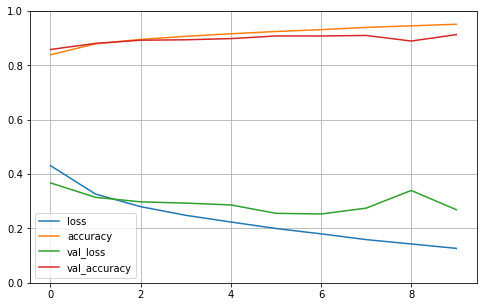

In [17]:
pd.DataFrame(best_model.history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)

3. Plot the confusion matrix. Which are the easy/hard categories to classify? Are there any particular
classes that often gets mixed together?

In [25]:
from sklearn.metrics import confusion_matrix
# print the confusion matrix
y_pred = best_model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
cm = confusion_matrix(y_test, y_pred)

classes = np.unique(y_test)

313/313 [==============================] - 3s 8ms/step


['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


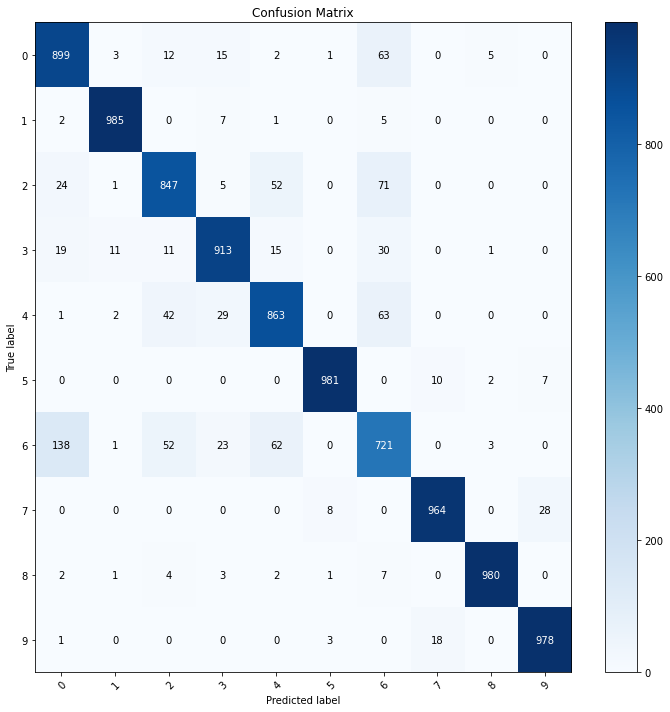

In [32]:
fig, ax = plt.subplots(figsize=(10, 10))
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)


ax.set(xticks=np.arange(cm.shape[1]),
       yticks=np.arange(cm.shape[0]),
       xticklabels=classes, yticklabels=classes,
       xlabel='Predicted label', ylabel='True label',
       title='Confusion Matrix',
       aspect='auto',
       ylim=(9.5, -0.5,))

plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], 'd'),
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black")

# Show the plot
plt.tight_layout()
print(class_names)

Seems like the predictions are pretty good. The only class that has a lot of misclassifications is the 6(shirt), which is often classified as 0(t-shirt/top) and there few missclassifications with class 2 and 4 (pullover, coat), which is expected. 
There are some more miss-classifications with class 2 and 4 (pullover, coat), which is also expected.
I was expecting to see some miss classifications regarding Sneakers and Ankle boots, but it seems like the model is able to distinguish them pretty well.